In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import datetime
import json
import os
#
from scipy import stats
import statistics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [2]:
activity_directory = "MyFitbitData/JT/Physical Activity/"
sleep_directory = "MyFitbitData/JT/Sleep/"

In [3]:
def get_time_worn():
    if os.path.exists("worn.csv"):
        df = pd.read_csv("worn.csv")
        df["date"] = pd.to_datetime(df["date"])
        return df
    else:
        df = pd.DataFrame(columns=["date", "worn"])
        for file in os.listdir(activity_directory):
            if file.startswith("time_in_heart_rate_zones"):
                #print(file)
                with open(activity_directory+file,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for entry in obj:
                        string_date = entry["dateTime"]
                        value_date = datetime.datetime.strptime(string_date,'%m/%d/%y %H:%M:%S')
                        value = entry["value"]
                        worn = value["valuesInZones"]["IN_DEFAULT_ZONE_1"] + \
                            value["valuesInZones"]["IN_DEFAULT_ZONE_2"] + \
                            value["valuesInZones"]["IN_DEFAULT_ZONE_3"] + \
                            value["valuesInZones"]["BELOW_DEFAULT_ZONE_1"]
                        #print("worn time ", worn, worn/60)
                        df = df.append({"date": value_date, "worn": worn/60.}, ignore_index = True)
        df.to_csv("worn.csv", index=False)
        return df

In [4]:
def get_activity(activity_list):
    if os.path.exists("activity.csv"):
        df = pd.read_csv("activity.csv")
        df["date"] = pd.to_datetime(df["date"])
    else:
        for i, name in enumerate(activity_list):
            df_values = pd.DataFrame(columns=["date", name])
            for file in os.listdir(activity_directory):
                if file.startswith(name):
                    print(file)
                    with open(activity_directory+file,"r") as f:
                        data = f.read()
                        obj = json.loads(data)
                        for entry in obj:
                            string_date = entry["dateTime"]
                            value_date = datetime.datetime.strptime(string_date,'%m/%d/%y %H:%M:%S')
                            value = entry["value"]
                            if name=="resting_heart_rate":
                                value=value["value"]
                            df_values = df_values.append({'date': value_date, name: float(value)}, ignore_index = True)
            df_values["date"] = pd.to_datetime(df_values["date"])
            df_grouped = df_values.groupby([df_values["date"].dt.date]).sum().reset_index()
            df_grouped["date"] = pd.to_datetime(df_grouped["date"])
            df_grouped[name] = df_grouped[name].astype(float)

            if name=="steps":
                df_grouped=df_grouped[df_grouped[name]>0]
            if name=="distance":
                df_grouped[name] = df_grouped[name]/1e5 # From cm to km
            if name=="resting_heart_rate":
                df_grouped=df_grouped[df[name]>0]

            if(i==0):
                df = df_grouped
            else:
                df = pd.merge(df, df_grouped,  on="date")

        df.to_csv("activity.csv", index=False)
    return df

In [5]:
def get_sleep():

    if os.path.exists("sleep.csv"):
        df_sleep = pd.read_csv("sleep.csv")
        df_sleep["date"] = pd.to_datetime(df_sleep["date"])
        return df_sleep

    else:
        df_sleep = pd.read_csv(sleep_directory+"sleep_score.csv")
        df_sleep["date"] = pd.to_datetime(df_sleep['timestamp'])
        # Timestamp is the time at which the user wakes up. Need to substract one day to match with the activities of that day
        df_sleep["date"] = pd.to_datetime(df_sleep["date"].dt.date) - datetime.timedelta(days=1)
        df_sleep = df_sleep.drop(['sleep_log_entry_id', 'timestamp', 'composition_score', 'revitalization_score', 'duration_score'], axis=1)
        df_sleep = df_sleep.rename(columns={"overall_score" : "score", "deep_sleep_in_minutes" : "deep", "resting_heart_rate" : "resting_heart"})

        df_values = pd.DataFrame(columns=["date", "sleep_start", "duration"])
        for file in os.listdir(sleep_directory):
            if file.startswith("sleep-"):
                print(file)
                with open(sleep_directory+file,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for entry in obj:
                        string_date = entry["dateOfSleep"]
                        value_date = datetime.datetime.strptime(string_date,'%Y-%m-%d')
                        value_date -= datetime.timedelta(days=1)
                        value_start = entry["startTime"]
                        # Remove excess .000 in seconds:
                        value_start = value_start.split(" ")
                        value_start[-1] = value_start[-1][:-4]
                        value_start = " ".join(value_start)
                        # Convert to date and store
                        value_start = datetime.datetime.strptime(value_start, '%Y-%m-%dT%H:%M:%S' )
                        time = value_start.hour + value_start.minute/60
                        if not(time>4. and time<20.):
                            if(time>12. and time<24):
                                time -= 24.
                            duration = entry["duration"]/(60*60*1000.)
                            df_values = df_values.append({'date': value_date, 'sleep_start': time, 'duration': duration}, ignore_index = True)

        df = pd.merge(df_sleep, df_values,  on="date")

        df.to_csv("sleep.csv", index=False)
        return df

In [6]:
def get_vo2max():
    if os.path.exists("vo2max.csv"):
        df_vo2 = pd.read_csv("vo2max.csv")
        df_vo2["date"] = pd.to_datetime(df_vo2["date"])
        return df_vo2
    else:
        df = pd.DataFrame(columns=["date", "vo2max"])
        file = "run_vo2_max-2020-10-11.json"
        with open(activity_directory+file,"r") as f:
            data = f.read()
            obj = json.loads(data)
            for entry in obj:
                string_date = entry["dateTime"]
                value_date = datetime.datetime.strptime(string_date,'%m/%d/%y %H:%M:%S')
                value = entry["value"]
                vo2max = value["runVO2Max"]
                df = df.append({"date": value_date, "vo2max": vo2max}, ignore_index = True)
        df["date"] = pd.to_datetime(df["date"])
        df.to_csv("vo2max.csv", index=False)
        return df

In [7]:
def get_exercice():
    if os.path.exists("exercice.csv"):
        df_ex = pd.read_csv("exercice.csv")
        df_ex["date"] = pd.to_datetime(df_ex["date"])
        return df_ex
    else:
        df = pd.DataFrame(columns=["date", "ex_name", "ex_duration"])
        for file in os.listdir(activity_directory):
            if file.startswith("exercise-"):
                with open(activity_directory+file,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for entry in obj:
                        string_date = entry["startTime"]
                        value_date = datetime.datetime.strptime(string_date,'%m/%d/%y %H:%M:%S')
                        name = entry["activityName"]
                        duration = entry["activeDuration"]/(60.*1000) # Convert to minutes
                        df = df.append({"date": value_date, "ex_name": name, "ex_duration": duration}, ignore_index = True)
        df["date"] = pd.to_datetime(df["date"].dt.date)
        df.to_csv("exercice.csv", index=False)
        return df

Now get activity data:

In [8]:
var_list=["steps", "distance", "calories", 
          "sedentary_minutes", "lightly_active_minutes", "moderately_active_minutes", "very_active_minutes"]
df = get_activity(var_list)
df = df.rename(columns={"sedentary_minutes" : "sed",
                        "lightly_active_minutes" : "light",
                        "moderately_active_minutes" : "fair",
                        "very_active_minutes" : "very"
                        })
print(df.head())

        date    steps  distance  calories     sed  light  fair  very
0 2020-10-12   5506.0    5.5011   2074.09  1376.0   32.0   3.0  29.0
1 2020-10-13  10209.0    9.2299   2504.04  1258.0  119.0   9.0  54.0
2 2020-10-14   8354.0    7.7593   2468.71   719.0  147.0   3.0  31.0
3 2020-10-15  11178.0   10.5760   2715.16   679.0  198.0   7.0  48.0
4 2020-10-16  12096.0   10.8236   2704.68   736.0  140.0  19.0  59.0


Get sleep data and add it to activity data:

In [9]:
df_sleep = get_sleep()
df = pd.merge(df_sleep, df,  on="date")
df = df[df.duration>1.5]

df['active'] = df['light'] + df['fair'] + df['very']
df['day_of_week'] = df['date'].dt.day_name()

Get data on how long the fitbit was worn on a given day. Only keep days where the fitbit was worn more than 20 hours. Then drop the "worn" data since we do not need it any longer.

In [10]:
df_worn = get_time_worn()
df = pd.merge(df, df_worn,  on="date")
df = df[df.worn>20.]
df = df.drop(["worn"], axis=1)

Let's also look at my exercice data:

In [11]:
df_ex = get_exercice()
df_ex = df_ex.drop(df_ex[df_ex.ex_name == "Walk"].index)

print('Workout list')
print(df_ex.groupby([df_ex["ex_name"]]).size().sort_values(ascending=False) )

# Sometimes I forget to turn off my watch after a workout. Let's set up a realistic maximum workout length:
df_ex.loc[(df_ex["ex_name"]=="Workout") & (df_ex["ex_duration"]>45.), "ex_duration"]=45.
df_ex.loc[(df_ex["ex_name"]=="Yoga") & (df_ex["ex_duration"]>45.), "ex_duration"]=45.

# If I did two workouts in the same day, let's merge them:
df_ex = df_ex[['date', 'ex_duration']]
df_ex = df_ex.groupby([df_ex["date"].dt.date]).sum().reset_index()
df_ex["date"] = pd.to_datetime(df_ex["date"])

Workout list
ex_name
Run             62
Workout         55
Outdoor Bike     5
Elliptical       4
Bike             2
Spinning         2
Sport            2
Yoga             1
dtype: int64


Merge exercice dataframe with main dataframe. Do a left join to keep all values of the main dataframe. At the dates where I did not exercice, simply add a 0 in exercice duration.

In [12]:
df = pd.merge(df, df_ex,  on="date", how='left').fillna(0)
df = df.sort_values(by=["date"])
print(df.describe())

            score        deep  resting_heart  restlessness  sleep_start  \
count  147.000000  147.000000     147.000000    147.000000   147.000000   
mean    76.931973   82.863946      51.333333      0.124215     0.391723   
std      6.242431   20.710212       2.203153      0.020680     0.759945   
min     55.000000   31.000000      47.000000      0.089268    -1.833333   
25%     74.000000   69.000000      50.000000      0.108692    -0.100000   
50%     77.000000   84.000000      51.000000      0.121711     0.300000   
75%     81.000000   97.000000      53.000000      0.135369     0.775000   
max     89.000000  135.000000      58.000000      0.217890     3.000000   

         duration         steps    distance     calories         sed  \
count  147.000000    147.000000  147.000000   147.000000  147.000000   
mean     7.847279   9167.911565    7.203921  2639.788367  714.693878   
std      1.080425   4219.675366    3.381614   347.662301   82.160019   
min      3.566667   2717.000000    2

### Let's look at some sleep-related number

In [13]:
print("Average sleep score: {:.0f}".format(df.score.mean() ) )
print("Average time in deep sleep: {:.0f} minutes".format(df["deep"].mean() ) )
print("Average resting heart rate: {:.1f} bpm".format(df["resting_heart"].mean() ) )

Average sleep score: 77
Average time in deep sleep: 83 minutes
Average resting heart rate: 51.3 bpm


### And some activity-related numbers

In [14]:
print("Average number of steps per day: {:.0f}".format(df.steps.mean()))
print("Average distance per day: {:.1f} km".format(df.distance.mean()))
print("Average calories per day: {:.0f} ".format(df.calories.mean()) )
print("Average sedentary minutes day: {:.0f} minutes".format(df.sed.mean()), "minutes")
print("Average lightly active minutes day: {:.0f} minutes".format(df.light.mean()), "minutes")
print("Average moderately active minutes day: {:.0f} minutes".format(df.fair.mean()), "minutes")
print("Average very active minutes day: {:.0f} minutes".format(df.very.mean()), "minutes")

Average number of steps per day: 9168
Average distance per day: 7.2 km
Average calories per day: 2640 
Average sedentary minutes day: 715 minutes minutes
Average lightly active minutes day: 206 minutes minutes
Average moderately active minutes day: 17 minutes minutes
Average very active minutes day: 27 minutes minutes


# Correlation plot #
Taken from [this page](https://github.com/lkippenb/Machine-Learning-Fitbit-Sleep)


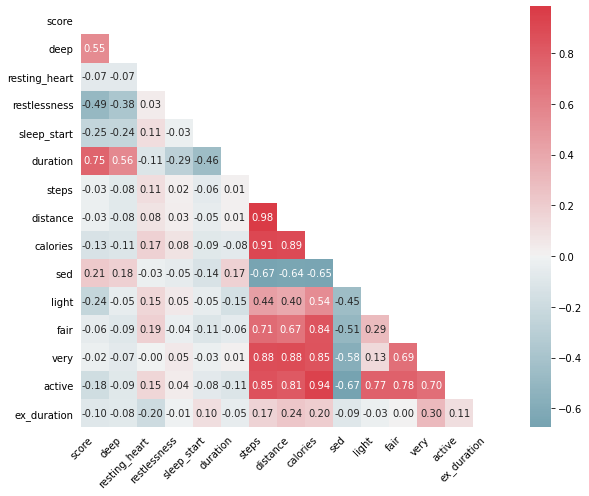

In [15]:
# Compute the correlation matrix
corr = df.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, cmap=cmap, center=0,
            square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

Sleep score correlates strongly with duration, as expected. Strangely, it also correlates positively with sedentarity, but negatively with active minutes.

As expected, my sleeping score correlates very strongly with the amount of deep sleep I get, and anti-correlates with how restless my night was. More interestingly, my sleeping score has a negative correlation with my activity and the amount of calories I burnt. This suggest that maybe I should not practice sport in the evening like I tend to do.

Now let's look at the days where I have been more active than usual (for instance if I walked a lot during the day):

When I'm more active than average, then sleep score scales positively with activity.

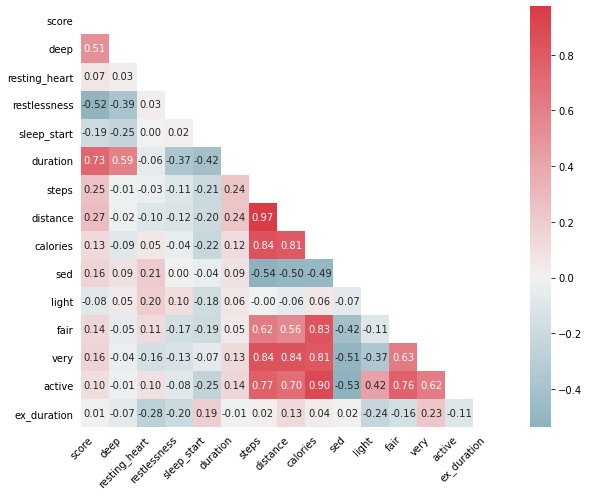

In [16]:
df_active = df[df.active>df.active.mean()]

# Compute the correlation matrix
corr = df_active.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, cmap=cmap, center=0,
            square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

Now the correlation between sleep score and activity (as well as steps or calories burnt) is slightly positive. This is more what I expected: if I walk a lot, I sleep slightly better.

Now let's visualize some of this data:

The linear correlation between sleep score and sleep duration clearly appears.

/tmp/ipykernel_373081/836971705.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


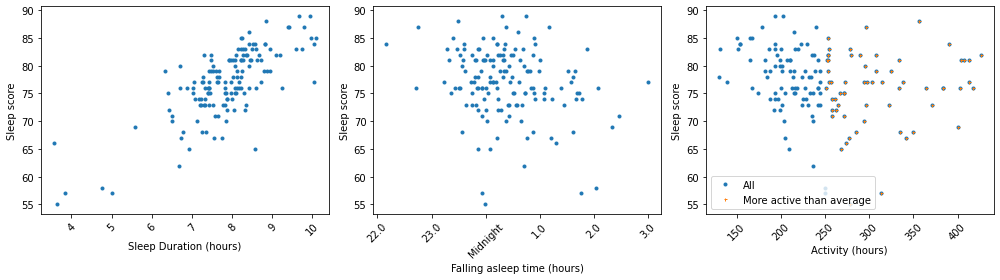

In [18]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
#
ax[0].plot(df["duration"], df["score"], 'C0.')
ax[0].set_xlabel("Sleep Duration (hours)")
ax[0].set_ylabel("Sleep score")
ax[0].tick_params(axis='x', labelrotation=45)
#
ax[1].plot(df["sleep_start"], df["score"], 'C0.')
ax[1].set_xlabel("Falling asleep time (hours)")
ax[1].set_ylabel("Sleep score")
ax[1].tick_params(axis='x', labelrotation=45)
labels=ax[1].get_xticks().tolist()
for k in range(len(labels)):
    if labels[k]<0:
        labels[k] = 24+labels[k]
    if labels[k]==0:
        labels[k]='Midnight'
ax[1].set_xticklabels(labels)
#
ax[2].plot(df["active"], df["score"], 'C0.', label='All')
ax[2].plot(df[df.active>df.active.mean()]["active"], df[df.active>df.active.mean()]["score"], 'C1+', ms=3, label='More active than average')
ax[2].set_xlabel("Activity (hours)")
ax[2].set_ylabel("Sleep score")
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].legend()
#
plt.tight_layout()
plt.show()

* Clearly, sleep duration leads to better sleep score (as expected).
* Regarding the time I fall asleep, it's less obvious, but the top right corner is completely empty, so as expected, my sleeping score is poor when I go to bed late or struggle to fall asleep.
* The correlation between sleep quality and activity is not obvious at first glance.
* I tend to sleep better on Friday nights, since that is also when I sleep the longest.

I sleep better on Friday nights, simply because I sleep longer.

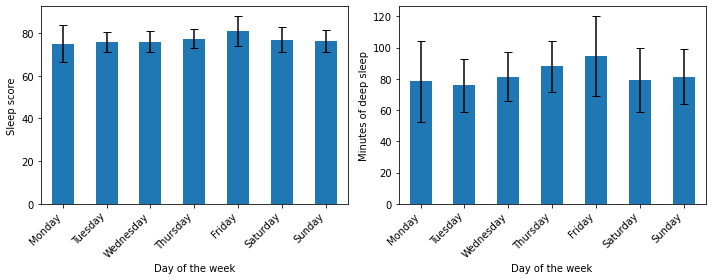

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#
std=df.groupby(df["day_of_week"]).score.std().reindex(DAYS, fill_value=0)
df.groupby(df["day_of_week"]).score.mean().reindex(DAYS, fill_value=0).plot(kind="bar", yerr = std, capsize=4, ax=ax[0])
ax[0].set_xlabel("Day of the week")
ax[0].set_ylabel("Sleep score")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
#
std=df.groupby(df["day_of_week"]).deep.std().reindex(DAYS, fill_value=0)
df.groupby(df["day_of_week"]).deep.mean().reindex(DAYS, fill_value=0).plot(kind="bar", yerr = std, capsize=4, ax=ax[1])
ax[1].set_xlabel("Day of the week")
ax[1].set_ylabel("Minutes of deep sleep")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
#
plt.tight_layout()
plt.show()

# Can we find a model that predicts the sleep score using the data at hand? #

Let's prepare the data.
* Sleep is complicated, and I don't think I have enough data at hand to understand it. However by looking at trends, I can maybe find ways to improve my sleep.
* I would like to see if I can predict my sleep score based on my daily activity: physical activity, sleep duration, etc... Based on the correlation plot above, I am not very hopeful, but let's see.
* Of course, parameters like deep sleep or restlessness matter a lot, but I have no control over them. All I have control over is what I do during the day.

In [22]:
min_max_scaler = preprocessing.MinMaxScaler()
columns = df.drop(["date", "day_of_week"], axis=1).columns
scaled_df = min_max_scaler.fit_transform(df.drop(["date", "day_of_week"], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=columns )

## Create a function which runs a bunch of different regression models ##

In [23]:
X = scaled_df[['duration','sleep_start', 'sed', 'calories']]
Y = scaled_df['score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=1234)

Here I aim at predicting my sleep score using my sleep duration, the time I fall asleep, my active minutes and the calories I burnt. Note that 'calories' and 'active' are probably correlated variables, since the more active I am during the day, the more calories I burn. 
Anyway, let's run several regressors and see how they perform at predicting my sleep score.

In [24]:

def get_prediction(model, df):
    if model=='MLR':
        reg = LinearRegression()
    if model=='RFG':
        reg = RandomForestRegressor()
    if model=='GBR':
        params = {'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 2,
                  'learning_rate': 0.01, 'loss': 'ls'}
        reg = GradientBoostingRegressor()
    if model=='SVR':
        reg = SVR()
    if model=='KNN':
        reg = neighbors.KNeighborsRegressor(5, weights='uniform')
    if model=='SGD':
        reg = SGDRegressor()
    if model=='EN':
        reg = ElasticNet()
    if model=='BR':
        reg = BayesianRidge()
    if model=='KRR':
        reg = KernelRidge()
    if model=='MLP':
        reg = MLPRegressor(random_state=1, max_iter=500)

    reg.fit(x_train, y_train)
    y_prediction = reg.predict(x_test)
    mae_test = mean_absolute_error(y_test, y_prediction)
    mse_test = mean_squared_error(y_test, y_prediction)
    r2score = r2_score(y_test,y_prediction)
    #print('Model:', model)
    #print("mean absolute error = {:.3f}".format(mae_test))
    #print("mean squared error = {:.3f}".format(mse_test))
    #print("r2 score {:.3f}".format(r2score))
    df = df.append({'model': model, 'mae': mae_test, 'mse': mse_test, 'r2': r2score}, ignore_index = True).round(4)
    return df

## Let's see how these regressors perfom ##

In [25]:
models = ['MLR', 'RFG', 'GBR', 'SVR', 'KNN', 'SGD', 'EN', 'BR', 'KRR', 'MLP']

df_reg = pd.DataFrame(columns=["model", "mae", "mse", "r2"])
for model in models:
    df_reg = get_prediction(model, df_reg)

print(df_reg.sort_values(by='r2', ascending=False))

  model     mae     mse      r2
0   MLR  0.0929  0.0150  0.6625
7    BR  0.0943  0.0154  0.6532
8   KRR  0.1001  0.0180  0.5950
3   SVR  0.0963  0.0187  0.5799
2   GBR  0.1109  0.0204  0.5414
1   RFG  0.1218  0.0245  0.4497
4   KNN  0.1235  0.0266  0.4032
9   MLP  0.1216  0.0304  0.3169
5   SGD  0.1307  0.0342  0.2322
6    EN  0.1453  0.0460 -0.0326


### Conclusions

* Overall, there are a few regressor with similar r^2 score and errors. None of them perform very well. In fact, the best r^2 score was for the simple multi-linear regression. This is because sleep score scales linearly with its strongest feature: sleep duration.
* This goes to show that sleep is complicated. It is not possible to accurately predict sleep score based only on sleep duration, sleep starting time, and physical activity. Factors like stress or temperature should also be investigated.
* The finding that my sleep quality decreases with activity was surprising. Perharps I exercice too late in the day? This suggest that I should change the time of the day at which I exercice. 